In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

In [17]:
from sklearn.decomposition import PCA
from sklearn.manifold import MDS, TSNE
import umap

In [2]:
train = pd.read_csv("train_mushrooms.csv")
test = pd.read_csv("test_mushrooms.csv")
ss = pd.read_csv("sample_submission.csv")

In [3]:
train.info(memory_usage="deep")

<class 'pandas.DataFrame'>
RangeIndex: 3116945 entries, 0 to 3116944
Data columns (total 22 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   class                 str    
 2   cap-diameter          float64
 3   cap-shape             str    
 4   cap-surface           str    
 5   cap-color             str    
 6   does-bruise-or-bleed  str    
 7   gill-attachment       str    
 8   gill-spacing          str    
 9   gill-color            str    
 10  stem-height           float64
 11  stem-width            float64
 12  stem-root             str    
 13  stem-surface          str    
 14  stem-color            str    
 15  veil-type             str    
 16  veil-color            str    
 17  has-ring              str    
 18  ring-type             str    
 19  spore-print-color     str    
 20  habitat               str    
 21  season                str    
dtypes: float64(3), int64(1), str(18)
memory usage: 2.7 GB

In [4]:
train

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0,e,8.80,f,s,u,f,a,c,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,1,p,4.51,x,h,o,f,a,c,n,...,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,2,e,6.94,f,s,b,f,x,c,w,...,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,3,e,3.88,f,y,g,f,s,NaN,g,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,4,e,5.85,x,l,w,f,d,NaN,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3116940,3116940,e,9.29,f,NaN,n,t,NaN,NaN,w,...,b,NaN,w,u,w,t,g,NaN,d,u
3116941,3116941,e,10.88,s,NaN,w,t,d,c,p,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
3116942,3116942,p,7.82,x,e,e,f,a,NaN,w,...,NaN,NaN,y,NaN,w,t,z,NaN,d,a
3116943,3116943,e,9.45,p,i,n,t,e,NaN,p,...,NaN,y,w,NaN,NaN,t,p,NaN,d,u


In [5]:
train.isna().sum() / len(train) * 100

id                       0.000000
class                    0.000000
cap-diameter             0.000128
cap-shape                0.001283
cap-surface             21.528227
cap-color                0.000385
does-bruise-or-bleed     0.000257
gill-attachment         16.809280
gill-spacing            40.373988
gill-color               0.001829
stem-height              0.000000
stem-width               0.000000
stem-root               88.452732
stem-surface            63.551362
stem-color               0.001219
veil-type               94.884350
veil-color              87.936970
has-ring                 0.000770
ring-type                4.134818
spore-print-color       91.425482
habitat                  0.001444
season                   0.000000
dtype: float64

In [6]:
train["class"].value_counts()

class
p    1705396
e    1411549
Name: count, dtype: int64

In [7]:
train.drop(["id", "stem-root", "stem-surface", "veil-type", "veil-color", "spore-print-color"], axis=1, inplace=True)

In [8]:
y = (train["class"] == "p").astype("int8").values
x = train.drop("class", axis=1)

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)

In [10]:
def preprocess_train(x_train):
    info = {}
    
    info["cap-diameter_mean"] = x_train["cap-diameter"].mean()
    x_train["cap-diameter"] = x_train["cap-diameter"].fillna(info["cap-diameter_mean"])
    x_train["cap-diameter"] = x_train["cap-diameter"].astype("float32")

    info["cap-shape_val"] = "x"
    x_train["cap-shape"] = x_train["cap-shape"].fillna(info["cap-shape_val"])
    info["cap_shape_keys"] = list(x_train["cap-shape"].value_counts()[:4].index)
    for k in info["cap_shape_keys"]:
        x_train[f"cap_shape_{k}"] = (x_train["cap-shape"] == k).astype("int8")
    x_train[f"cap_shape_other"] = (~x_train["cap-shape"].isin(info["cap_shape_keys"])).astype("int8")
    x_train.drop("cap-shape", axis=1, inplace=True)

    cap_surface_dict = x_train['cap-surface'].value_counts(normalize=True)[:11]
    cap_surface_dict = cap_surface_dict / cap_surface_dict.sum()
    info["cap_surface_dict"] = cap_surface_dict

    def cp_cap_surface(x):
        if isinstance(x, float) and np.isnan(x):
            return np.random.choice(info["cap_surface_dict"].index, p=info["cap_surface_dict"].values)
        elif x in info["cap_surface_dict"].index:
            return x
        else:
            return 'other'

    x_train["cap-surface"] = x_train["cap-surface"].apply(cp_cap_surface)

    info["cap-surface_values"] = x_train["cap-surface"].value_counts()
    for k in info["cap-surface_values"].keys():
        x_train[f"cap-surface-{k}"] =  (x_train["cap-surface"] == k).astype("int8")
    x_train.drop('cap-surface', axis=1, inplace=True)

    info['cap-color-val'] = 'n'
    x_train['cap-color'] = x_train['cap-color'].fillna(info['cap-color-val'])

    info['cap-color-keys'] = list(x_train['cap-color'].value_counts()[:6].keys())
    for k in info['cap-color-keys']:
        x_train[f"cap_color_{k}"] = (x_train["cap-color"] == k).astype("int8")
    x_train[f"cap_color_other"] = (~x_train["cap-color"].isin(info["cap-color-keys"])).astype("int8")
    x_train.drop("cap-color", axis=1, inplace=True)

    info['does-bruise-or-bleed'] = 'f'
    x_train['does-bruise-or-bleed'] = x_train['does-bruise-or-bleed'].fillna(info['does-bruise-or-bleed'])

    x_train["does-bruise-or-bleed"] = (x_train["does-bruise-or-bleed"] == 'f').astype("int8")

    gill_attachment_dict = x_train['gill-attachment'].value_counts(normalize=True)[:7]
    gill_attachment_dict = gill_attachment_dict / gill_attachment_dict.sum()
    info['gill_attachment_dict'] = gill_attachment_dict

    def cp_gill_attachment(x):
        if isinstance(x, float) and np.isnan(x):
            return np.random.choice(info['gill_attachment_dict'].index, p=info['gill_attachment_dict'].values)
        elif x in info['gill_attachment_dict'].index:
            return x
        else:
            return 'other'

    x_train["gill-attachment"] = x_train["gill-attachment"].apply(cp_gill_attachment)

    info["gill-attachment-values"] = x_train["gill-attachment"].value_counts()
    for k in info["gill-attachment-values"].keys():
        x_train[f"gill-attachment-{k}"] = (x_train["gill-attachment"] == k).astype("int8")

    x_train.drop("gill-attachment", axis=1, inplace=True)

    info["gill-spacing-val"] = 'c'
    x_train["gill-spacing"] = x_train["gill-spacing"].fillna(info["gill-spacing-val"])
    
    x_train["gill-spacing"] = (x_train["gill-spacing"] == 'c').astype("int8")

    gill_color_dict = x_train['gill-color'].value_counts(normalize=True)[:12]
    gill_color_dict = gill_color_dict / gill_color_dict.sum()
    info['gill_color_dict'] = gill_color_dict

    def cp_gill_color(x):
        if isinstance(x, float) and np.isnan(x):
            return np.random.choice(info['gill_color_dict'].index, p=info['gill_color_dict'].values)
        elif x in info['gill_color_dict'].index:
            return x
        else:
            return 'other'

    x_train["gill-color"] = x_train["gill-color"].apply(cp_gill_color)

    info['gill-color-keys'] = list(x_train['gill-color'].value_counts()[:12].keys())
    for k in info['gill-color-keys']:
        x_train[f"gill_color_{k}"] = (x_train["gill-color"] == k).astype("int8")
    x_train.drop("gill-color", axis=1, inplace=True)
    
    info["stem-color-val"] = 'w' 
    x_train["stem-color"] = x_train["stem-color"].fillna(info["stem-color-val"])

    info['stem-color-keys'] = list(x_train['stem-color'].value_counts()[:6].keys())
    
    for k in info['stem-color-keys']:
        x_train[f"stem-color_{k}"] = (x_train["stem-color"] == k).astype("int8")
    x_train.drop("stem-color", axis=1, inplace=True)

    info["has-ring-val"] = 'f'
    x_train["has-ring"] = x_train["has-ring"].fillna(info["has-ring-val"])

    x_train["has-ring"] = (x_train["has-ring"] == "f").astype("int8")

    ring_type_dict = x_train['ring-type'].value_counts(normalize=True)[:7]
    ring_type_dict = ring_type_dict / ring_type_dict.sum()
    info["ring_type_dict"] = ring_type_dict

    def cp_ring_type(x):
        if isinstance(x, float) and np.isnan(x):
            return np.random.choice(info["ring_type_dict"].index, p=info["ring_type_dict"].values)
        elif x in info["ring_type_dict"].index:
            return x
        else:
            return 'other'

    x_train["ring-type"] = x_train["ring-type"].apply(cp_ring_type)

    info["ring-type-values"] = x_train["ring-type"].value_counts()
    for k in info["ring-type-values"].keys():
        x_train[f"ring_type_{k}"] = (x_train["ring-type"] == k).astype("int8")

    x_train.drop(["ring_type_f","ring-type"], axis=1, inplace=True)

    info["habitat-val"] = 'd'
    x_train["habitat"] = x_train["habitat"].fillna(info["habitat-val"])

    info['habitat-keys'] = list(x_train['habitat'].value_counts()[:4].keys())

    for k in info['habitat-keys']:
        x_train[f"habitat_{k}"] = (x_train["habitat"] == k).astype("int8")
    x_train[f"habitat_other"] = (~x_train["habitat"].isin(info["habitat-keys"])).astype("int8")
    x_train.drop("habitat", axis=1, inplace=True)

    info["season-values"] = x_train["season"].value_counts()
    for k in info["season-values"].keys():
        x_train[f"season_{k}"] = (x_train["season"] == k).astype("int8")
    x_train.drop("season", axis=1, inplace=True)

    return x_train, info

In [11]:
x_train, info = preprocess_train(x_train)
x_train

,cap-diameter,does-bruise-or-bleed,gill-spacing,stem-height,stem-width,has-ring,cap_shape_x,cap_shape_f,cap_shape_s,cap_shape_b,...,ring_type_other,habitat_d,habitat_g,habitat_l,habitat_m,habitat_other,season_a,season_u,season_w,season_s
1249285,6.11,1,1,12.72,16.36,1,0,0,0,1,...,0,1,0,0,0,0,1,0,0,0
1952332,10.42,0,1,6.73,17.74,1,0,0,1,0,...,0,1,0,0,0,0,1,0,0,0
2912806,1.86,1,1,3.63,2.46,1,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
136822,8.65,1,1,7.82,28.50,1,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0
552456,4.86,1,1,5.57,11.25,1,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2249467,8.96,1,1,9.34,27.54,1,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
963395,7.39,1,0,5.99,12.80,1,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0
2215104,1.94,1,1,5.41,2.12,1,0,0,0,1,...,0,1,0,0,0,0,1,0,0,0
1484405,3.58,1,1,3.47,8.04,1,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0


In [12]:
def preprocess_test(x_test, info):

    x_test["cap-diameter"] = x_test["cap-diameter"].fillna(info["cap-diameter_mean"])
    x_test["cap-diameter"] = x_test["cap-diameter"].astype("float32")

    x_test["cap-shape"] = x_test["cap-shape"].fillna(info["cap-shape_val"])
    
    for k in info["cap_shape_keys"]:
        x_test[f"cap_shape_{k}"] = (x_test["cap-shape"] == k).astype("int8")
    x_test[f"cap_shape_other"] = (~x_test["cap-shape"].isin(info["cap_shape_keys"])).astype("int8")
    x_test.drop("cap-shape", axis=1, inplace=True)

    def cp_cap_surface(x):
        if isinstance(x, float) and np.isnan(x):
            return np.random.choice(info["cap_surface_dict"].index, p=info["cap_surface_dict"].values)
        elif x in info["cap_surface_dict"].index:
            return x
        else:
            return 'other'

    x_test["cap-surface"] = x_test["cap-surface"].apply(cp_cap_surface)

    for k in info["cap-surface_values"].keys():
        x_test[f"cap-surface-{k}"] =  (x_test["cap-surface"] == k).astype("int8")
    x_test.drop('cap-surface', axis=1, inplace=True)

    x_test['cap-color'] = x_test['cap-color'].fillna(info['cap-color-val'])

    for k in info['cap-color-keys']:
        x_test[f"cap_color_{k}"] = (x_test["cap-color"] == k).astype("int8")
    x_test[f"cap_color_other"] = (~x_test["cap-color"].isin(info["cap-color-keys"])).astype("int8")
    x_test.drop("cap-color", axis=1, inplace=True)

    x_test['does-bruise-or-bleed'] = x_test['does-bruise-or-bleed'].fillna(info['does-bruise-or-bleed'])

    x_test["does-bruise-or-bleed"] = (x_test["does-bruise-or-bleed"] == 'f').astype("int8")

    def cp_gill_attachment(x):
        if isinstance(x, float) and np.isnan(x):
            return np.random.choice(info['gill_attachment_dict'].index, p=info['gill_attachment_dict'].values)
        elif x in info['gill_attachment_dict'].index:
            return x
        else:
            return 'other'

    x_test["gill-attachment"] = x_test["gill-attachment"].apply(cp_gill_attachment)

    for k in info["gill-attachment-values"].keys():
        x_test[f"gill-attachment-{k}"] = (x_test["gill-attachment"] == k).astype("int8")
    x_test.drop("gill-attachment", axis=1, inplace=True)

    x_test["gill-spacing"] = x_test["gill-spacing"].fillna(info["gill-spacing-val"])
    
    x_test["gill-spacing"] = (x_test["gill-spacing"] == 'c').astype("int8")

    def cp_gill_color(x):
        if isinstance(x, float) and np.isnan(x):
            return np.random.choice(info['gill_color_dict'].index, p=info['gill_color_dict'].values)
        elif x in info['gill_color_dict'].index:
            return x
        else:
            return 'other'

    x_test["gill-color"] = x_test["gill-color"].apply(cp_gill_color)

    for k in info['gill-color-keys']:
        x_test[f"gill_color_{k}"] = (x_test["gill-color"] == k).astype("int8")
    x_test.drop("gill-color", axis=1, inplace=True)
    
    x_test["stem-color"] = x_test["stem-color"].fillna(info["stem-color-val"])

    for k in info['stem-color-keys']:
        x_test[f"stem-color_{k}"] = (x_test["stem-color"] == k).astype("int8")
    x_test.drop("stem-color", axis=1, inplace=True)

    x_test["has-ring"] = x_test["has-ring"].fillna(info["has-ring-val"])

    x_test["has-ring"] = (x_test["has-ring"] == "f").astype("int8")

    def cp_ring_type(x):
        if isinstance(x, float) and np.isnan(x):
            return np.random.choice(info["ring_type_dict"].index, p=info["ring_type_dict"].values)
        elif x in info["ring_type_dict"].index:
            return x
        else:
            return 'other'

    x_test["ring-type"] = x_test["ring-type"].apply(cp_ring_type)

    for k in info["ring-type-values"].keys():
        x_test[f"ring_type_{k}"] = (x_test["ring-type"] == k).astype("int8")
    x_test.drop(["ring_type_f","ring-type"], axis=1, inplace=True)

    x_test["habitat"] = x_test["habitat"].fillna(info["habitat-val"])

    for k in info['habitat-keys']:
        x_test[f"habitat_{k}"] = (x_test["habitat"] == k).astype("int8")
    x_test[f"habitat_other"] = (~x_test["habitat"].isin(info["habitat-keys"])).astype("int8")
    x_test.drop("habitat", axis=1, inplace=True)

    for k in info["season-values"].keys():
        x_test[f"season_{k}"] = (x_test["season"] == k).astype("int8")
    x_test.drop("season", axis=1, inplace=True)

    return x_test

In [13]:
x_test = preprocess_test(x_test, info)
x_test

,cap-diameter,does-bruise-or-bleed,gill-spacing,stem-height,stem-width,has-ring,cap_shape_x,cap_shape_f,cap_shape_s,cap_shape_b,...,ring_type_other,habitat_d,habitat_g,habitat_l,habitat_m,habitat_other,season_a,season_u,season_w,season_s
430964,4.29,1,1,9.95,6.09,0,0,0,0,1,...,0,0,1,0,0,0,0,0,1,0
1907082,4.12,1,1,5.70,3.98,1,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
2626732,6.18,1,1,4.02,12.81,0,0,1,0,0,...,0,0,0,0,0,1,0,1,0,0
38950,4.43,0,1,6.03,6.37,1,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0
96583,12.14,0,1,7.60,29.43,1,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304798,5.51,1,1,6.31,8.18,1,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0
1796005,10.30,0,1,5.93,21.42,1,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0
104462,1.78,1,1,6.81,3.24,1,0,0,0,1,...,0,0,0,0,1,0,0,1,0,0
52439,2.23,1,1,6.22,3.16,1,0,0,0,1,...,0,0,1,0,0,0,1,0,0,0


In [14]:
scaler = MinMaxScaler()
x_train_sc = scaler.fit_transform(x_train)
x_test_sc = scaler.transform(x_test)

In [27]:
model = LogisticRegression()
model.fit(x_train_sc, y_train)
y_pred_test = model.predict(x_test_sc)
y_pred_train = model.predict(x_train_sc)
print(classification_report(y_test, y_pred_test)), print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.72      0.74      0.73    353076
           1       0.78      0.77      0.77    426161

    accuracy                           0.75    779237
   macro avg       0.75      0.75      0.75    779237
weighted avg       0.75      0.75      0.75    779237

              precision    recall  f1-score   support

           0       0.72      0.74      0.73   1058473
           1       0.78      0.77      0.77   1279235

    accuracy                           0.75   2337708
   macro avg       0.75      0.75      0.75   2337708
weighted avg       0.75      0.75      0.75   2337708



(None, None)

In [28]:
pca = PCA(n_components=2)
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)
x_train_pca.shape, x_test_pca.shape

((2337708, 2), (779237, 2))

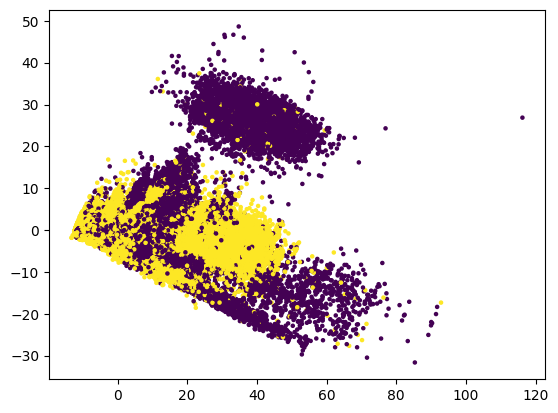

In [24]:
plt.scatter(x_train_pca[:, 0], x_train_pca[:, 1], s=5, c=y_train);

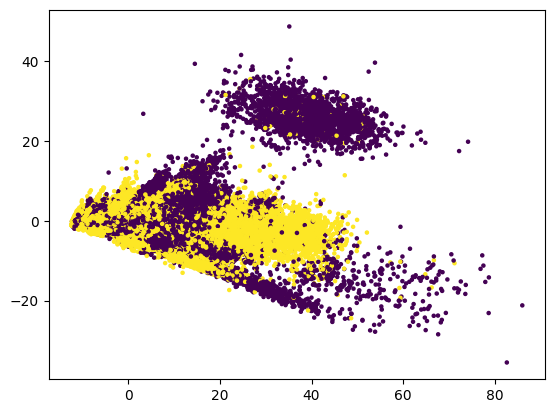

In [30]:
plt.scatter(x_test_pca[:, 0], x_test_pca[:, 1], s=5, c=y_test);

In [31]:
model = LogisticRegression()
model.fit(x_train_pca, y_train)
y_pred_test = model.predict(x_test_pca)
y_pred_train = model.predict(x_train_pca)
print(classification_report(y_test, y_pred_test)), print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.58      0.34      0.43    353076
           1       0.59      0.80      0.68    426161

    accuracy                           0.59    779237
   macro avg       0.59      0.57      0.55    779237
weighted avg       0.59      0.59      0.57    779237

              precision    recall  f1-score   support

           0       0.58      0.34      0.43   1058473
           1       0.59      0.79      0.68   1279235

    accuracy                           0.59   2337708
   macro avg       0.59      0.57      0.55   2337708
weighted avg       0.59      0.59      0.57   2337708



(None, None)

In [32]:
model = GaussianNB()
model.fit(x_train_pca, y_train)
y_pred_test = model.predict(x_test_pca)
y_pred_train = model.predict(x_train_pca)
print(classification_report(y_test, y_pred_test)), print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.50      0.19      0.28    353076
           1       0.56      0.84      0.67    426161

    accuracy                           0.55    779237
   macro avg       0.53      0.52      0.47    779237
weighted avg       0.53      0.55      0.49    779237

              precision    recall  f1-score   support

           0       0.50      0.19      0.28   1058473
           1       0.56      0.84      0.67   1279235

    accuracy                           0.55   2337708
   macro avg       0.53      0.52      0.47   2337708
weighted avg       0.53      0.55      0.49   2337708



(None, None)

In [38]:
model = DecisionTreeClassifier(max_depth=10)
model.fit(x_train_pca, y_train)
y_pred_test = model.predict(x_test_pca)
y_pred_train = model.predict(x_train_pca)
print(classification_report(y_test, y_pred_test)), print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.66      0.70      0.68    353076
           1       0.74      0.70      0.72    426161

    accuracy                           0.70    779237
   macro avg       0.70      0.70      0.70    779237
weighted avg       0.70      0.70      0.70    779237

              precision    recall  f1-score   support

           0       0.66      0.70      0.68   1058473
           1       0.74      0.71      0.72   1279235

    accuracy                           0.70   2337708
   macro avg       0.70      0.70      0.70   2337708
weighted avg       0.70      0.70      0.70   2337708



(None, None)